## Modelagem de Dados para o Desafio do Vinho

Autor : Natanael Junior (natmourajr@gmail.com)

### Objetivo do notebook

Criar uma modelagem estimar a qualidade do vinho através das outras variáveis disponíveis

### Fazer a carga das bibliotecas

In [2]:
%time
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


### Carga de dados do arquivo

In [3]:
%time
df = pd.read_csv('data/winequality.csv', sep=';')
df.head(10)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.58 µs


,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,White,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,White,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,White,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,White,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
5,White,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
6,White,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,6
7,White,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
8,White,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
9,White,8.1,0.22,0.43,1.5,0.044,28.0,129.0,0.9938,3.22,0.45,11,6


Mesmo pré-processamento aplicado anteriormente.

In [4]:
df.drop(df['alcohol'].loc[df['alcohol'].str.len()>10].index.values, axis=0, inplace=True)
df['alcohol'] = pd.to_numeric(df['alcohol'])

Como temos dois tipos de vinho, vou digitalizar esta variável. Aqui, eu escolhi arbitrariamente o vinho branco (com mais amostras) como 1 e o vermelho como 0

In [5]:
numeric_type = np.zeros_like(df['type'])
numeric_type[df['type'] == 'White'] = 1
df['type'] = numeric_type

Processando o conjunto total de dados para separar dados para modelar e alvo a ser modelado

In [6]:
col_list = df.columns.tolist()
col_list.remove('quality')
data = df[col_list]
trgt = df['quality']
trgt = trgt[:,np.newaxis]

Primeiro, vou tentar aplicar uma regressão logista (modelo mais simples e mais fácil de explicar os resultados).

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression

import joblib

# parametros de validação cruzada
nfolds = 4
foldshandler = StratifiedKFold(n_splits=nfolds)

# parametros do modelo
model_name = 'logreg'

#loop da validação cruzada
for ifold,(trainId,testId) in enumerate(foldshandler.split(data,trgt-3.)):
    #if ifold != 0: break
    data_scaler = MinMaxScaler().fit(data.values[trainId])
    
    norm_data = data_scaler.transform(data)
    norm_trgt = trgt-3.0
    
    model = LogisticRegression(C=10, penalty='l2',solver='saga',
                               multi_class='multinomial',max_iter=10000)
    
    model.fit(norm_data[trainId],norm_trgt[trainId,0])
    
    # save model
    joblib.dump(model,'models/model_%s_folds_%i_fold_%i.jbl'%(model_name,nfolds,ifold))
    
    #save output and normalized target
    prediction = model.predict(norm_data)
    prediction = prediction[np.newaxis,:].T
    
    train_id = np.zeros_like(prediction)
    train_id[trainId] = 1
    test_id = np.zeros_like(prediction)
    test_id[testId] = 1
    df_out = pd.DataFrame(np.append(np.append(norm_trgt,prediction,axis=1),np.append(train_id,test_id,axis=1),axis=1), 
                          columns=['target','output', 'train_id', 'test_id'])
    with open('models/outputs_%s_folds_%i_fold_%i.csv'%(model_name,nfolds,ifold), mode='w') as f:
        df_out.to_csv(f, index = False)
    

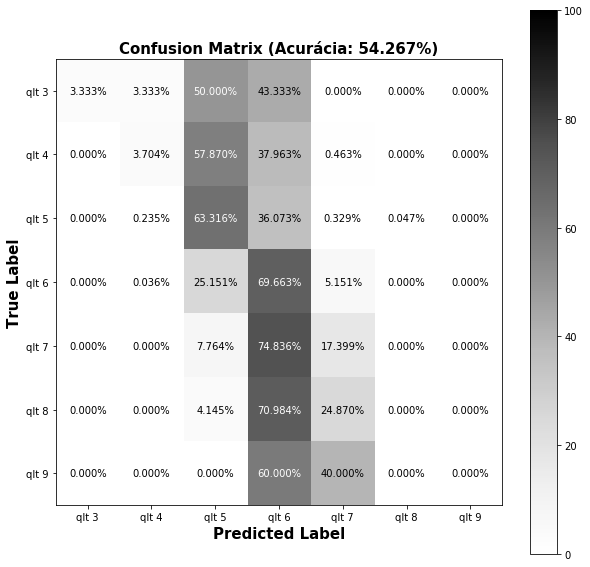

In [11]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

nfolds = 4
ifold = 0
model_name = 'logreg'
out_name = 'models/outputs_%s_folds_%i_fold_%i.csv'%(model_name,nfolds,ifold)
df_out = pd.read_csv(out_name,index_col=None)
m_labels = ['qlt 3', 'qlt 4', 'qlt 5', 'qlt 6', 'qlt 7', 'qlt 8', 'qlt 9']

accuracy = accuracy_score(df_out['target'], df_out['output'])

fig = plt.figure(figsize=(10,10))
cm = confusion_matrix(df_out['target'],df_out['output'])
cm = cm.astype('float')/ cm.sum(axis=1)[:, np.newaxis]
cm_normalized = 100.*cm
ax = plt.subplot(1,1,1)
im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Greys,clim=(0.0, 100.0))
width, height = cm_normalized.shape
for x in range(width):
    for y in range(height):
        if cm_normalized[x][y] < 50.:
            ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center')
        else:
            ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center',color='white')

ax.set_title('Confusion Matrix (Acurácia: %1.3f%%)'%(100.*accuracy),fontweight='bold',fontsize=15)
fig.colorbar(im)
tick_marks = np.arange(len(m_labels))
ax.xaxis.set_ticks(tick_marks)
ax.xaxis.set_ticklabels(m_labels)

ax.yaxis.set_ticks(tick_marks)
ax.yaxis.set_ticklabels(m_labels)

ax.set_ylabel('True Label',fontweight='bold',fontsize=15);
ax.set_xlabel('Predicted Label',fontweight='bold',fontsize=15);


Um modelo de bagging pode ser útil para diminuir a variância associada as classes com menos amostras.

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier

import joblib

# parametros de validação cruzada
nfolds = 4
foldshandler = StratifiedKFold(n_splits=nfolds)

# parametros do modelo
model_name = 'bagging_logreg'

#loop da validação cruzada
for ifold,(trainId,testId) in enumerate(foldshandler.split(data,trgt-3.)):
    #if ifold != 0: break
    data_scaler = MinMaxScaler().fit(data.values[trainId])
    
    norm_data = data_scaler.transform(data)
    norm_trgt = trgt-3.0
    
    base_model = LogisticRegression(C=10, penalty='l2',solver='saga',
                               multi_class='multinomial',max_iter=10000)
    model = BaggingClassifier(base_estimator=base_model,n_estimators=10, random_state=0).fit(norm_data[trainId],norm_trgt[trainId,0])
    
    #model.fit(norm_data[trainId],norm_trgt[trainId,0])
    
    # save model
    joblib.dump(model,'models/model_%s_folds_%i_fold_%i.jbl'%(model_name,nfolds,ifold))
    
    #save output and normalized target
    prediction = model.predict(norm_data)
    prediction = prediction[np.newaxis,:].T
    
    train_id = np.zeros_like(prediction)
    train_id[trainId] = 1
    test_id = np.zeros_like(prediction)
    test_id[testId] = 1
    df_out = pd.DataFrame(np.append(np.append(norm_trgt,prediction,axis=1),np.append(train_id,test_id,axis=1),axis=1), 
                          columns=['target','output', 'train_id', 'test_id'])
    with open('models/outputs_%s_folds_%i_fold_%i.csv'%(model_name,nfolds,ifold), mode='w') as f:
        df_out.to_csv(f, index = False)
    

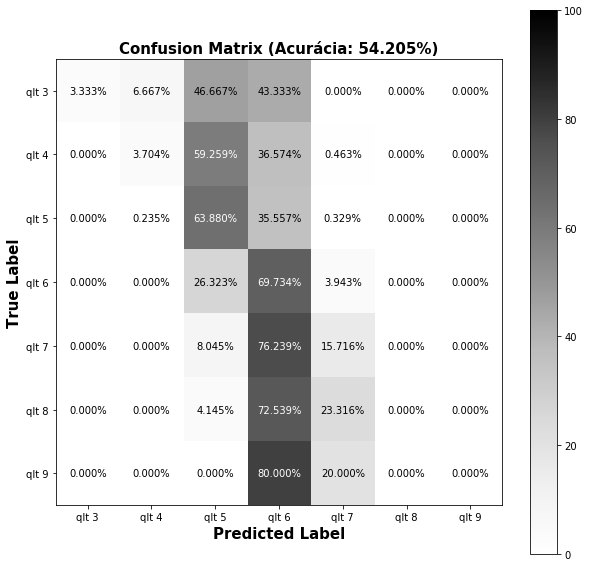

In [91]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

nfolds = 4
ifold = 0
model_name = 'bagging_logreg'
out_name = 'models/outputs_%s_folds_%i_fold_%i.csv'%(model_name,nfolds,ifold)
df_out = pd.read_csv(out_name,index_col=None)
m_labels = ['qlt 3', 'qlt 4', 'qlt 5', 'qlt 6', 'qlt 7', 'qlt 8', 'qlt 9']

accuracy = accuracy_score(df_out['target'], df_out['output'])

fig = plt.figure(figsize=(10,10))
cm = confusion_matrix(df_out['target'],df_out['output'])
cm = cm.astype('float')/ cm.sum(axis=1)[:, np.newaxis]
cm_normalized = 100.*cm
ax = plt.subplot(1,1,1)
im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Greys,clim=(0.0, 100.0))
width, height = cm_normalized.shape
for x in range(width):
    for y in range(height):
        if cm_normalized[x][y] < 50.:
            ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center')
        else:
            ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center',color='white')

ax.set_title('Confusion Matrix (Acurácia: %1.3f%%)'%(100.*accuracy),fontweight='bold',fontsize=15)
fig.colorbar(im)
tick_marks = np.arange(len(m_labels))
ax.xaxis.set_ticks(tick_marks)
ax.xaxis.set_ticklabels(m_labels)

ax.yaxis.set_ticks(tick_marks)
ax.yaxis.set_ticklabels(m_labels)

ax.set_ylabel('True Label',fontweight='bold',fontsize=15);
ax.set_xlabel('Predicted Label',fontweight='bold',fontsize=15);


O segundo modelo que vai ser testado é uma árvore de decisão

In [94]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

import joblib

# parametros de validação cruzada
nfolds = 4
foldshandler = StratifiedKFold(n_splits=nfolds)

# parametros do modelo
model_name = 'decisiontree'
maxdepth = 30

#loop da validação cruzada
for ifold,(trainId,testId) in enumerate(foldshandler.split(data,trgt-3.0)):
    #if ifold != 0: break
    #data_scaler = MinMaxScaler().fit(data.values[trainId])
    
    norm_data = data.values
    norm_trgt = trgt-3.0
    
    
    for idepth in range(1,maxdepth+1):
        model = RandomForestClassifier(max_depth = idepth, n_estimators=10);

        model.fit(norm_data[trainId],norm_trgt[trainId,0])
        model = model.estimators_[1]
    
        # save model
        joblib.dump(model,'models/model_%s_depth_%i_folds_%i_fold_%i.jbl'%(model_name,idepth,nfolds,ifold))
    
        #save output and normalized target
        prediction = model.predict(norm_data)
        prediction = prediction[np.newaxis,:].T
    
        train_id = np.zeros_like(prediction)
        train_id[trainId] = 1
        test_id = np.zeros_like(prediction)
        test_id[testId] = 1
        df_out = pd.DataFrame(np.append(np.append(norm_trgt,prediction,axis=1),np.append(train_id,test_id,axis=1),axis=1), 
                              columns=['target','output', 'train_id', 'test_id'])
        with open('models/outputs_%s_depth_%i_folds_%i_fold_%i.csv'%(model_name,idepth,nfolds,ifold), mode='w') as f:
            df_out.to_csv(f, index = False)

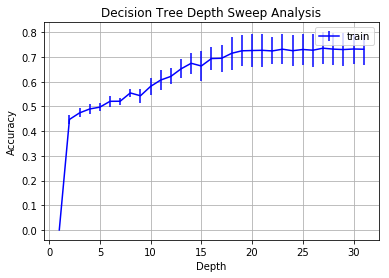

In [19]:
import joblib

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# parametros de validação cruzada
nfolds = 4

# parametros do modelo
model_name = 'decisiontree'
maxdepth = 30

train_acc_mat = np.zeros([nfolds,maxdepth+1])
test_acc_mat = np.zeros([nfolds,maxdepth+1])

#loop da validação cruzada
for ifold,(trainId,testId) in enumerate(foldshandler.split(data)):
    #if ifold != 0: break
    for idepth in range(1,maxdepth+1):
        out_name = 'models/outputs_%s_depth_%i_folds_%i_fold_%i.csv'%(model_name,idepth,nfolds,ifold)
        df_out = pd.read_csv(out_name,index_col=None)
        accuracy = accuracy_score(df_out[train_id==1]['target'], df_out[train_id==1]['output'])
        train_acc_mat[ifold,int(idepth)] = accuracy
        accuracy = accuracy_score(df_out[test_id==1]['target'], df_out[test_id==1]['output'])
        test_acc_mat[ifold,int(idepth)] = accuracy

        
fig = plt.figure(figsize=(6,4))

ax = plt.subplot(1,1,1)

ax.errorbar(np.linspace(1,maxdepth+1,maxdepth+1), np.mean(train_acc_mat,axis=0), np.std(train_acc_mat,axis=0), color = 'b')
#ax.errorbar(np.linspace(1,maxdepth+1,maxdepth+1), np.mean(test_acc_mat,axis=0), np.std(test_acc_mat,axis=0), color = 'r')

ax.set_title('Decision Tree Depth Sweep Analysis')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Depth')
ax.legend(['train', 'validation'], loc='best')
ax.grid()

Podemos ver aqui que depois de 20 níveis de profundidade, não há benefício estatístico nenhum (empate na barra de erro) em se adicionar outro nível.

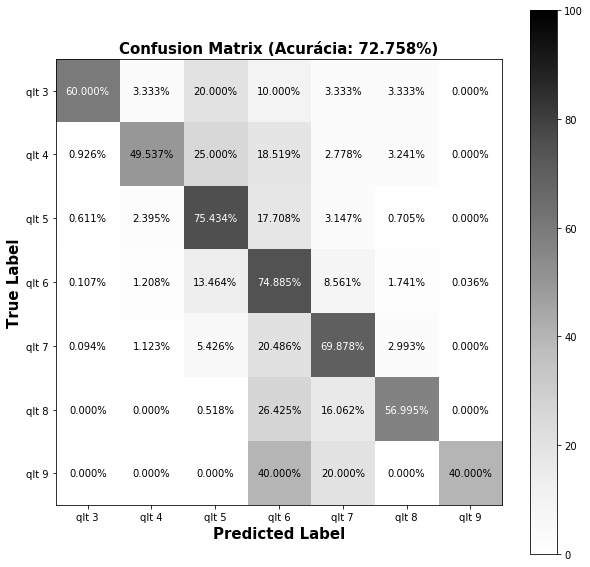

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

nfolds = 4
ifold = 1
model_name = 'decisiontree'
depth = 20
out_name = 'models/outputs_%s_depth_%i_folds_%i_fold_%i.csv'%(model_name,depth,nfolds,ifold)
df_out = pd.read_csv(out_name,index_col=None)
m_labels = ['qlt 3', 'qlt 4', 'qlt 5', 'qlt 6', 'qlt 7', 'qlt 8', 'qlt 9']

accuracy = accuracy_score(df_out['target'], df_out['output'])

fig = plt.figure(figsize=(10,10))
cm = confusion_matrix(df_out['target'],df_out['output'])
cm = cm.astype('float')/ cm.sum(axis=1)[:, np.newaxis]
cm_normalized = 100.*cm
ax = plt.subplot(1,1,1)
im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Greys,clim=(0.0, 100.0))
width, height = cm_normalized.shape
for x in range(width):
    for y in range(height):
        if cm_normalized[x][y] < 50.:
            ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center')
        else:
            ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center',color='white')

ax.set_title('Confusion Matrix (Acurácia: %1.3f%%)'%(100.*accuracy),fontweight='bold',fontsize=15)
fig.colorbar(im)
tick_marks = np.arange(len(m_labels))
ax.xaxis.set_ticks(tick_marks)
ax.xaxis.set_ticklabels(m_labels)

ax.yaxis.set_ticks(tick_marks)
ax.yaxis.set_ticklabels(m_labels)

ax.set_ylabel('True Label',fontweight='bold',fontsize=15);
ax.set_xlabel('Predicted Label',fontweight='bold',fontsize=15);


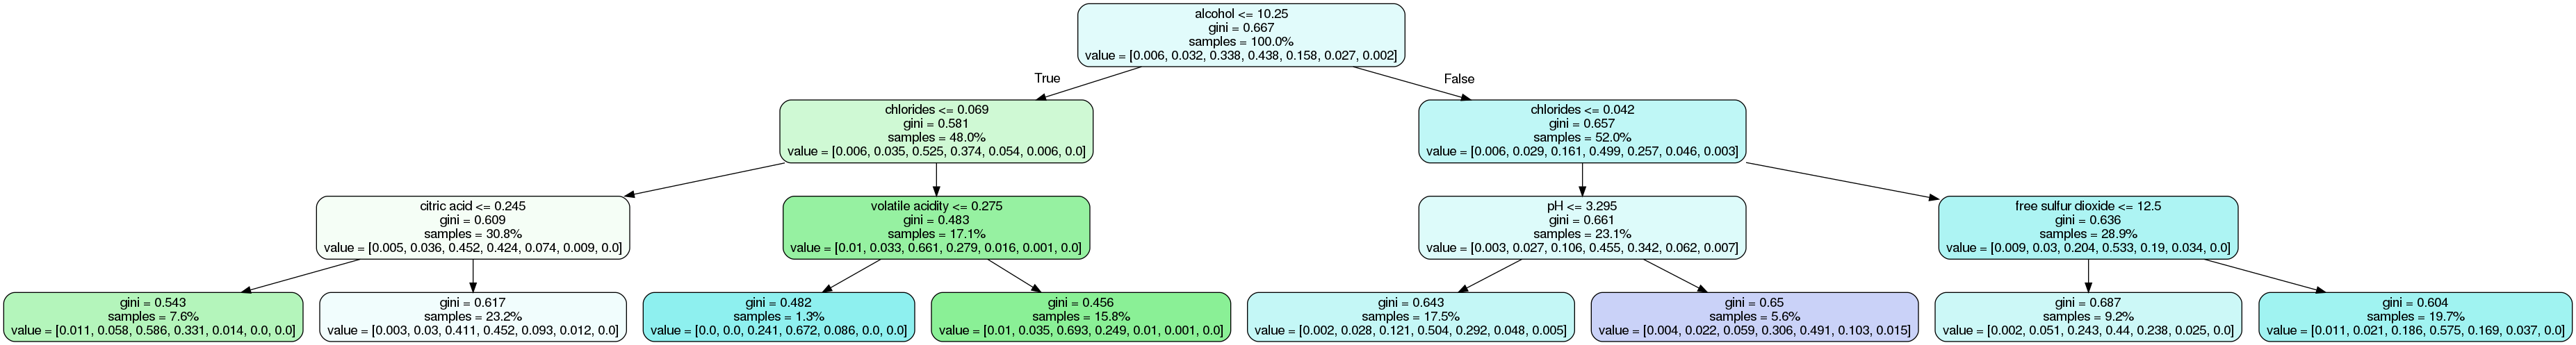

In [21]:
from sklearn.tree import export_graphviz
import pydotplus
import joblib

from IPython.display import Image

m_columns = ['type', 'fixed acidity', 'volatile acidity', 'citric acid',
             'residual sugar', 'chlorides', 'free sulfur dioxide',
             'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

nfolds = 4
ifold = 1
model_name = 'decisiontree'
depth = 3
model_name = 'models/model_%s_depth_%i_folds_%i_fold_%i.jbl'%(model_name,depth,nfolds,ifold)
model = joblib.load(model_name)

graph = export_graphviz(model, out_file=None, feature_names=m_columns, proportion = True, filled= True,rounded = True)
graph = pydotplus.graph_from_dot_data(graph)  
Image(graph.create_png())

O terceiro modelo a ser analisado é um modelo baseado em Máquinas de Vetor Suporte (SVM)

In [29]:
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from keras.utils import np_utils

import joblib

# parametros de validação cruzada
nfolds = 4
foldshandler = StratifiedKFold(n_splits=nfolds)

# parametros do modelo
model_name = 'svm'
kernel = 'linear'

kernels = ['linear']

#loop da validação cruzada
for ifold,(trainId,testId) in enumerate(foldshandler.split(data,trgt-3.)):
    if ifold != 0: break
    #data_scaler = MinMaxScaler().fit(data.values[trainId])
    
    norm_data = data.values
    norm_trgt = trgt-3.0
    norm_trgt = np_utils.to_categorical(trgt-3., np.unique(trgt-3.,axis=0).shape[0])
    class_weights = get_class_weights(norm_trgt[trainId])
       
    for ikernel, kernel_name in enumerate(kernels):
        #model = svm.SVC(kernel='linear', class_weight=class_weights)
        model = svm.SVC(kernel='linear')

        model.fit(norm_data[trainId],trgt[trainId]-3.0)
        
        # save model
        joblib.dump(model,'models/model_%s_kernel_%s_folds_%i_fold_%i.jbl'%(model_name,kernel_name,nfolds,ifold))
    
        #save output and normalized target
        prediction = model.predict(norm_data)
        prediction = prediction[np.newaxis,:].T
    
        train_id = np.zeros_like(prediction)
        train_id[trainId] = 1
        test_id = np.zeros_like(prediction)
        test_id[testId] = 1
        df_out = pd.DataFrame(np.append(np.append(trgt-3.,prediction,axis=1),np.append(train_id,test_id,axis=1),axis=1), 
                              columns=['target','output', 'train_id', 'test_id'])
        with open('models/outputs_%s_kernel_%s_folds_%i_fold_%i.csv'%(model_name,kernel_name,nfolds,ifold), mode='w') as f:
            df_out.to_csv(f, index = False)

/home/natmourajr/.virtualenvs/wine/lib/python3.5/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


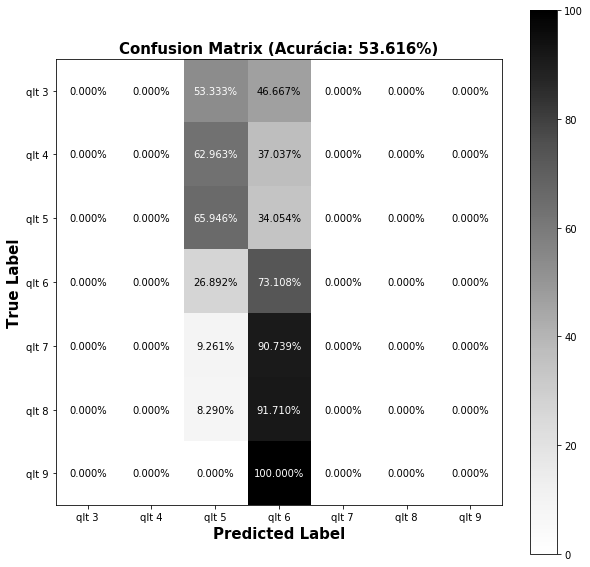

In [30]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

nfolds = 4
ifold = 0
model_name = 'svm'
kernel_name = 'linear'
out_name = 'models/outputs_%s_kernel_%s_folds_%i_fold_%i.csv'%(model_name,kernel_name,nfolds,ifold)
df_out = pd.read_csv(out_name,index_col=None)
m_labels = ['qlt 3', 'qlt 4', 'qlt 5', 'qlt 6', 'qlt 7', 'qlt 8', 'qlt 9']

accuracy = accuracy_score(df_out['target'], df_out['output'])

fig = plt.figure(figsize=(10,10))
cm = confusion_matrix(df_out['target'],df_out['output'])
cm = cm.astype('float')/ cm.sum(axis=1)[:, np.newaxis]
cm_normalized = 100.*cm
ax = plt.subplot(1,1,1)
im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Greys,clim=(0.0, 100.0))
width, height = cm_normalized.shape
for x in range(width):
    for y in range(height):
        if cm_normalized[x][y] < 50.:
            ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center')
        else:
            ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center',color='white')

ax.set_title('Confusion Matrix (Acurácia: %1.3f%%)'%(100.*accuracy),fontweight='bold',fontsize=15)
fig.colorbar(im)
tick_marks = np.arange(len(m_labels))
ax.xaxis.set_ticks(tick_marks)
ax.xaxis.set_ticklabels(m_labels)

ax.yaxis.set_ticks(tick_marks)
ax.yaxis.set_ticklabels(m_labels)

ax.set_ylabel('True Label',fontweight='bold',fontsize=15);
ax.set_xlabel('Predicted Label',fontweight='bold',fontsize=15);


Como tem um desbalanço muito forte entre as classes, vou fazer um teste com cada classe sendo pesada

In [37]:
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from keras.utils import np_utils

import joblib


# função para equilibrio entre classes desbalanceadas
def get_class_weights(trgt, mode='standard'):
    if trgt.ndim > 1:
        trgt = trgt.argmax(axis=1)

    cls_indices, event_count = np.unique(np.array(trgt), return_counts=True)
    min_class = min(event_count)

    return {cls_index: float(min_class) / cls_count
            for cls_index, cls_count in zip(cls_indices, event_count)}


# parametros de validação cruzada
nfolds = 4
foldshandler = StratifiedKFold(n_splits=nfolds)

# parametros do modelo
model_name = 'svm_class_weighted'

kernels = ['linear', 'rbf', 'polynomial', 'sigmoid']

#loop da validação cruzada
for ifold,(trainId,testId) in enumerate(foldshandler.split(data,trgt-3.)):
    #if ifold != 0: break
    #data_scaler = MinMaxScaler().fit(data.values[trainId])
    
    norm_data = data.values
    norm_trgt = trgt-3.0
    norm_trgt = np_utils.to_categorical(trgt-3., np.unique(trgt-3.,axis=0).shape[0])
    class_weights = get_class_weights(norm_trgt[trainId])
       
    for ikernel, kernel_name in enumerate(kernels):
        model = svm.SVC(kernel='linear', class_weight=class_weights)

        model.fit(norm_data[trainId],trgt[trainId]-3.0)
        
        # save model
        joblib.dump(model,'models/model_%s_kernel_%s_folds_%i_fold_%i.jbl'%(model_name,kernel_name,nfolds,ifold))
    
        #save output and normalized target
        prediction = model.predict(norm_data)
        prediction = prediction[np.newaxis,:].T
    
        train_id = np.zeros_like(prediction)
        train_id[trainId] = 1
        test_id = np.zeros_like(prediction)
        test_id[testId] = 1
        df_out = pd.DataFrame(np.append(np.append(trgt-3.,prediction,axis=1),np.append(train_id,test_id,axis=1),axis=1), 
                              columns=['target','output', 'train_id', 'test_id'])
        with open('models/outputs_%s_kernel_%s_folds_%i_fold_%i.csv'%(model_name,kernel_name,nfolds,ifold), mode='w') as f:
            df_out.to_csv(f, index = False)
        accuracy = accuracy_score(trgt[trainId]-3., prediction[trainId])
        print("Train model of %i fold of %i folds with kernel %s -> Acc: %1.5f"%(ifold+1, nfolds, kernel_name,accuracy))

/home/natmourajr/.virtualenvs/wine/lib/python3.5/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train model of 1 fold of 4 folds with kernel linear -> Acc: 0.26518


/home/natmourajr/.virtualenvs/wine/lib/python3.5/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train model of 1 fold of 4 folds with kernel rbf -> Acc: 0.26518


/home/natmourajr/.virtualenvs/wine/lib/python3.5/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train model of 1 fold of 4 folds with kernel polynomial -> Acc: 0.26518


/home/natmourajr/.virtualenvs/wine/lib/python3.5/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train model of 1 fold of 4 folds with kernel sigmoid -> Acc: 0.26518


/home/natmourajr/.virtualenvs/wine/lib/python3.5/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train model of 2 fold of 4 folds with kernel linear -> Acc: 0.23580


/home/natmourajr/.virtualenvs/wine/lib/python3.5/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train model of 2 fold of 4 folds with kernel rbf -> Acc: 0.23580


/home/natmourajr/.virtualenvs/wine/lib/python3.5/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train model of 2 fold of 4 folds with kernel polynomial -> Acc: 0.23580


/home/natmourajr/.virtualenvs/wine/lib/python3.5/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train model of 2 fold of 4 folds with kernel sigmoid -> Acc: 0.23580


/home/natmourajr/.virtualenvs/wine/lib/python3.5/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train model of 3 fold of 4 folds with kernel linear -> Acc: 0.23167


/home/natmourajr/.virtualenvs/wine/lib/python3.5/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train model of 3 fold of 4 folds with kernel rbf -> Acc: 0.23167


/home/natmourajr/.virtualenvs/wine/lib/python3.5/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train model of 3 fold of 4 folds with kernel polynomial -> Acc: 0.23167


/home/natmourajr/.virtualenvs/wine/lib/python3.5/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train model of 3 fold of 4 folds with kernel sigmoid -> Acc: 0.23167


/home/natmourajr/.virtualenvs/wine/lib/python3.5/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train model of 4 fold of 4 folds with kernel linear -> Acc: 0.26100


/home/natmourajr/.virtualenvs/wine/lib/python3.5/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train model of 4 fold of 4 folds with kernel rbf -> Acc: 0.26100


/home/natmourajr/.virtualenvs/wine/lib/python3.5/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train model of 4 fold of 4 folds with kernel polynomial -> Acc: 0.26100


/home/natmourajr/.virtualenvs/wine/lib/python3.5/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train model of 4 fold of 4 folds with kernel sigmoid -> Acc: 0.26100


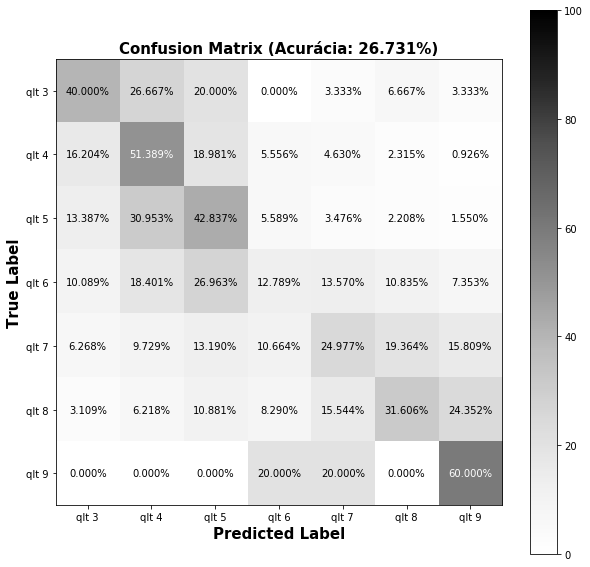

In [34]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

nfolds = 4
ifold = 0
model_name = 'svm_class_weighted'
kernel_name = 'linear'
out_name = 'models/outputs_%s_kernel_%s_folds_%i_fold_%i.csv'%(model_name,kernel_name,nfolds,ifold)
df_out = pd.read_csv(out_name,index_col=None)
m_labels = ['qlt 3', 'qlt 4', 'qlt 5', 'qlt 6', 'qlt 7', 'qlt 8', 'qlt 9']

accuracy = accuracy_score(df_out['target'], df_out['output'])

fig = plt.figure(figsize=(10,10))
cm = confusion_matrix(df_out['target'],df_out['output'])
cm = cm.astype('float')/ cm.sum(axis=1)[:, np.newaxis]
cm_normalized = 100.*cm
ax = plt.subplot(1,1,1)
im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Greys,clim=(0.0, 100.0))
width, height = cm_normalized.shape
for x in range(width):
    for y in range(height):
        if cm_normalized[x][y] < 50.:
            ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center')
        else:
            ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center',color='white')

ax.set_title('Confusion Matrix (Acurácia: %1.3f%%)'%(100.*accuracy),fontweight='bold',fontsize=15)
fig.colorbar(im)
tick_marks = np.arange(len(m_labels))
ax.xaxis.set_ticks(tick_marks)
ax.xaxis.set_ticklabels(m_labels)

ax.yaxis.set_ticks(tick_marks)
ax.yaxis.set_ticklabels(m_labels)

ax.set_ylabel('True Label',fontweight='bold',fontsize=15);
ax.set_xlabel('Predicted Label',fontweight='bold',fontsize=15);


O terceiro modelo a ser aplicado será uma rede neural artificial (pelos motivos descritos no notebook de EDA).

In [91]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler


from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from keras.utils import np_utils
from keras.optimizers import Adadelta, Adam
from keras.callbacks import EarlyStopping

model_name = 'mlp'
topo = 40

min_topo = 4
max_topo = 41

lr = 1e-2
epochs = 100
opt = Adam(learning_rate=lr, decay=lr/epochs)
verbose = 0


# parametros de validação cruzada
nfolds = 4
foldshandler = StratifiedKFold(n_splits=nfolds)


for ifold,(trainId,testId) in enumerate(foldshandler.split(data,trgt-3.)):
    
    if ifold != 0: break
    data_scaler = MinMaxScaler().fit(data.values[trainId])  
    norm_data = data_scaler.transform(data)
    
    # encode class values as integers
    encoder = LabelEncoder()
    encoder.fit(trgt-3.0)
    encoded_trgt = encoder.transform(trgt-3.0)
    # convert integers to dummy variables (i.e. one hot encoded)
    #norm_trgt = 2*np_utils.to_categorical(encoded_trgt) -1
    norm_trgt = np_utils.to_categorical(encoded_trgt)
    
    
    for itopo in range(min_topo, max_topo):
        model = Sequential()
        model.add(Dense(itopo, input_dim=norm_data.shape[1], activation='relu'))
        model.add(Dense(norm_trgt.shape[1], activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['categorical_crossentropy','mse','mae'])
        #model.summary()
        
        # early stopping 
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=verbose, patience=20)

        history = model.fit(norm_data, norm_trgt, epochs=epochs, batch_size=28,  
                            verbose=verbose, validation_split=0.3, callbacks=[es])

        #save model
        model.save('models/model_%s_topo_%i_folds_%i_fold_%i_entropy.h5'%(model_name,itopo,nfolds,ifold))

        # convert the history.history dict to a pandas DataFrame:     
        hist_df = pd.DataFrame(history.history) 
        with open('models/model_%s_hist_topo_%i_folds_%i_fold_%i.csv'%(model_name,itopo,nfolds,ifold), mode='w') as f:
            hist_df.to_csv(f)

        #save output and normalized target
        truth_class = norm_trgt.argmax(axis=1)
        truth_class = truth_class[:,np.newaxis]
        prediction = model.predict(norm_data)
        pred_class = prediction.argmax(axis=1)
        pred_class = pred_class[:,np.newaxis]
        train_id = np.zeros_like(pred_class)
        train_id[trainId] = 1
        test_id = np.zeros_like(pred_class)
        test_id[testId] = 1
        df_out = pd.DataFrame(np.append(np.append(truth_class,pred_class,axis=1),np.append(train_id,test_id,axis=1),axis=1), 
                              columns=['target','output', 'train_id', 'test_id'])
        with open('models/outputs_model_%s_topo_%i_folds_%i_fold_%i.csv'%(model_name,itopo,nfolds,ifold), mode='w') as f:
            df_out.to_csv(f, index = False)
        accuracy = accuracy_score(truth_class[trainId], pred_class[trainId])
        print("Train model of %i fold of %i folds with topology %i (from %i to %i) -> Acc: %1.5f"%(ifold+1, nfolds, itopo, min_topo, max_topo,accuracy))

/home/natmourajr/.virtualenvs/wine/lib/python3.5/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/natmourajr/.virtualenvs/wine/lib/python3.5/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train model of 1 fold of 4 folds with topology 4 (from 4 to 41) -> Acc: 0.43412
Train model of 1 fold of 4 folds with topology 5 (from 4 to 41) -> Acc: 0.44135
Train model of 1 fold of 4 folds with topology 6 (from 4 to 41) -> Acc: 0.41780
Train model of 1 fold of 4 folds with topology 7 (from 4 to 41) -> Acc: 0.52127
Train model of 1 fold of 4 folds with topology 8 (from 4 to 41) -> Acc: 0.56361
Train model of 1 fold of 4 folds with topology 9 (from 4 to 41) -> Acc: 0.53532
Train model of 1 fold of 4 folds with topology 10 (from 4 to 41) -> Acc: 0.49009
Train model of 1 fold of 4 folds with topology 11 (from 4 to 41) -> Acc: 0.54998
Train model of 1 fold of 4 folds with topology 12 (from 4 to 41) -> Acc: 0.47687
Train model of 1 fold of 4 folds with topology 13 (from 4 to 41) -> Acc: 0.54440
Train model of 1 fold of 4 folds with topology 14 (from 4 to 41) -> Acc: 0.47356
Train model of 1 fold of 4 folds with topology 15 (from 4 to 41) -> Acc: 0.53325
Train model of 1 fold of 4 folds w

Train model of 1 fold of 10 folds with topology 10 -> Acc: 0.36723


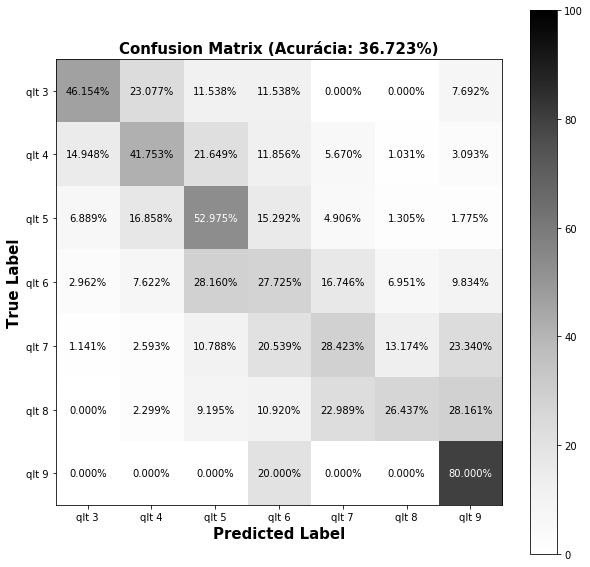

In [87]:
# Celula de desenvolvimento


# função para equilibrio entre classes desbalanceadas
def get_class_weights(trgt, mode='standard'):
    if trgt.ndim > 1:
        trgt = trgt.argmax(axis=1)

    cls_indices, event_count = np.unique(np.array(trgt), return_counts=True)
    min_class = min(event_count)

    return {cls_index: float(min_class) / cls_count
            for cls_index, cls_count in zip(cls_indices, event_count)}


from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler


from keras.models import Sequential, Model
from keras.layers import Dense, Input
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from keras.utils import np_utils
from keras.optimizers import Adadelta, Adam
from keras.callbacks import EarlyStopping
from keras import regularizers

model_name = 'mlp'
topo = 10

lr = 1e-3
epochs = 500
opt = Adam(learning_rate=lr, decay=lr/epochs)
verbose = 0


# parametros de validação cruzada
nfolds = 10
foldshandler = KFold(n_splits=nfolds)


for ifold,(trainId,testId) in enumerate(foldshandler.split(data)):
    
    if ifold != 0: break
    data_scaler = MinMaxScaler().fit(data.values[trainId])  
    norm_data = data_scaler.transform(data)
    
    # encode class values as integers
    norm_trgt = np_utils.to_categorical(trgt-3., np.unique(trgt-3.,axis=0).shape[0])
    class_weights = get_class_weights(norm_trgt[trainId])
    
    # model design
    #model = Sequential()
    #model.add(Dense(topo, input_dim=norm_data.shape[1], activation='tanh'))
    #model.add(Dense(norm_trgt.shape[1], activation='softmax'))
    input_layer = Input(shape=(norm_data.shape[1], ))
    hidden_layer = Dense(topo, activation='tanh', name='hidden_layer',kernel_regularizer=regularizers.l2(0.0001))(input_layer)
    output_layer = Dense(norm_trgt.shape[1], activation='softmax', name='output_layer')(hidden_layer)
    model = Model(input_layer, output_layer)

    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['categorical_crossentropy','mse','mae'])
    #model.summary()

    # early stopping 
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=verbose, patience=20)

    history = model.fit(norm_data[trainId], norm_trgt[trainId], epochs=epochs, batch_size=14,  
                        verbose=verbose, callbacks=[es], class_weight = class_weights,
                        validation_data=(norm_data[testId],norm_trgt[testId]))

    #save output and normalized target
    truth_class = norm_trgt.argmax(axis=1)
    truth_class = truth_class[:,np.newaxis]
    prediction = model.predict(norm_data)
    pred_class = prediction.argmax(axis=1)
    pred_class = pred_class[:,np.newaxis]
    train_id = np.zeros_like(pred_class)
    train_id[trainId] = 1
    test_id = np.zeros_like(pred_class)
    test_id[testId] = 1

    accuracy = accuracy_score(truth_class[trainId], pred_class[trainId])
    print("Train model of %i fold of %i folds with topology %i -> Acc: %1.5f"%(ifold+1, nfolds, topo,accuracy))
    
    m_labels = ['qlt 3', 'qlt 4', 'qlt 5', 'qlt 6', 'qlt 7', 'qlt 8', 'qlt 9']
    
    fig = plt.figure(figsize=(10,10))
    cm = confusion_matrix(truth_class[trainId], pred_class[trainId])
    cm = cm.astype('float')/ cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = 100.*cm
    ax = plt.subplot(1,1,1)
    im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Greys,clim=(0.0, 100.0))
    width, height = cm_normalized.shape
    for x in range(width):
        for y in range(height):
            if cm_normalized[x][y] < 50.:
                ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                            horizontalalignment='center',
                            verticalalignment='center')
            else:
                ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                            horizontalalignment='center',
                            verticalalignment='center',color='white')

    ax.set_title('Confusion Matrix (Acurácia: %1.3f%%)'%(100.*accuracy),fontweight='bold',fontsize=15)
    fig.colorbar(im)
    tick_marks = np.arange(len(m_labels))
    ax.xaxis.set_ticks(tick_marks)
    ax.xaxis.set_ticklabels(m_labels)

    ax.yaxis.set_ticks(tick_marks)
    ax.yaxis.set_ticklabels(m_labels)

    ax.set_ylabel('True Label',fontweight='bold',fontsize=15);
    ax.set_xlabel('Predicted Label',fontweight='bold',fontsize=15);


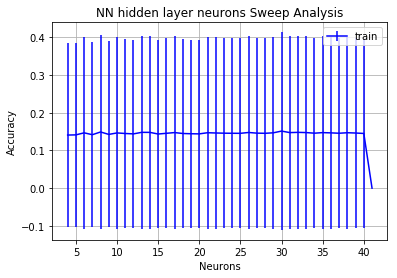

In [83]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# parametros de validação cruzada
nfolds = 4
foldshandler = KFold(n_splits=nfolds)

# parametros do modelo
model_name = 'mlp'
min_topo = 4
max_topo = 41

train_acc_mat = np.zeros([nfolds,max_topo-min_topo+1])
test_acc_mat = np.zeros([nfolds,max_topo-min_topo+1])

#loop da validação cruzada
for ifold,(trainId,testId) in enumerate(foldshandler.split(data)):
    if ifold != 0: break
    for itopo in range(min_topo, max_topo):
        out_name = 'models/outputs_model_%s_topo_%i_folds_%i_fold_%i.csv'%(model_name,itopo,nfolds,ifold)
        df_out = pd.read_csv(out_name,index_col=None)
        accuracy = accuracy_score(df_out[train_id==1]['target'], df_out[train_id==1]['output'])
        train_acc_mat[ifold,itopo-min_topo] = accuracy
        accuracy = accuracy_score(df_out[test_id==1]['target'], df_out[test_id==1]['output'])
        test_acc_mat[ifold,itopo-min_topo] = accuracy

        
fig = plt.figure(figsize=(6,4))

ax = plt.subplot(1,1,1)

ax.errorbar(np.linspace(min_topo,max_topo,max_topo-min_topo+1), np.mean(train_acc_mat,axis=0), np.std(train_acc_mat,axis=0), color = 'b')
#ax.errorbar(np.linspace(1,maxdepth+1,maxdepth+1), np.mean(test_acc_mat,axis=0), np.std(test_acc_mat,axis=0), color = 'r')

ax.set_title('NN hidden layer neurons Sweep Analysis')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Neurons')
ax.legend(['train', 'validation'], loc='best')
ax.grid()

Todos os modelos apresentaram quase os mesmos valores de acurácia. Isso pode ser explicado pelo forte desbalanceio entre as classes a serem analisadas. Uma das maneiras de mitigar este problema é dividindo o conjunto de desenvolvimento em dois. No primeiro, as classes 5, 6, 7 (muitos eventos) e uma classe que congrega as classes 3, 4, 8 e 9 (poucos eventos). Depois, um segundo processo de treinamento deve ser realizado, desta vez para separar as classes com poucos eventos.

Agrupar as classes 3, 4, 8 e 9

In [15]:
grouped_trgt = trgt
grouped_trgt[grouped_trgt == 3.] = 4.0
grouped_trgt[grouped_trgt == 8.] = 4.0
grouped_trgt[grouped_trgt == 9.] = 4.0

Train model of 1 fold of 4 folds with topology 200 -> Acc: 0.53532


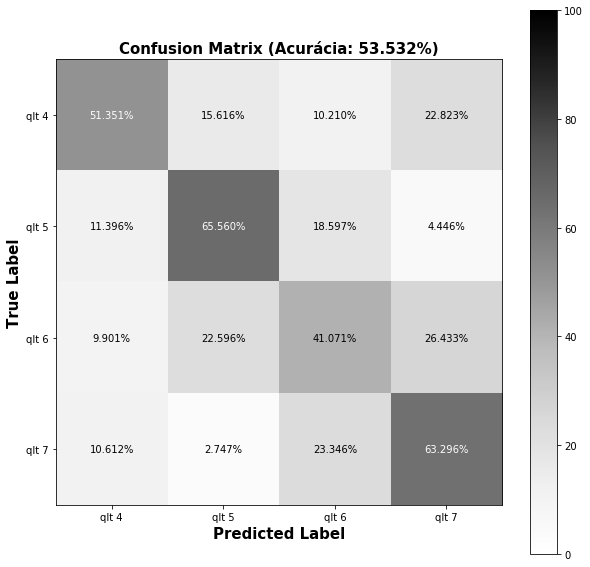

In [28]:
# Celula de desenvolvimento


# função para equilibrio entre classes desbalanceadas
def get_class_weights(trgt, mode='standard'):
    if trgt.ndim > 1:
        trgt = trgt.argmax(axis=1)

    cls_indices, event_count = np.unique(np.array(trgt), return_counts=True)
    min_class = min(event_count)

    return {cls_index: float(min_class) / cls_count
            for cls_index, cls_count in zip(cls_indices, event_count)}


from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler


from keras.models import Sequential, Model
from keras.layers import Dense, Input
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from keras.utils import np_utils
from keras.optimizers import Adadelta, Adam
from keras.callbacks import EarlyStopping
from keras import regularizers

model_name = 'mlp'
topo = 200

lr = 1e-3
epochs = 500
opt = Adam(learning_rate=lr, decay=lr/epochs)
verbose = 0


# parametros de validação cruzada
nfolds = 4
foldshandler = StratifiedKFold(n_splits=nfolds)


for ifold,(trainId,testId) in enumerate(foldshandler.split(data, grouped_trgt-4.)):
    
    if ifold != 0: break
    data_scaler = StandardScaler().fit(data.values[trainId])  
    norm_data = data_scaler.transform(data)
    
    # encode class values as integers
    norm_trgt = np_utils.to_categorical(grouped_trgt-4., np.unique(grouped_trgt-4.,axis=0).shape[0])
    class_weights = get_class_weights(norm_trgt[trainId])
    
    # model design
    #model = Sequential()
    #model.add(Dense(topo, input_dim=norm_data.shape[1], activation='tanh'))
    #model.add(Dense(norm_trgt.shape[1], activation='softmax'))
    input_layer = Input(shape=(norm_data.shape[1], ))
    hidden_layer = Dense(topo, activation='tanh', name='hidden_layer')(input_layer)
    output_layer = Dense(norm_trgt.shape[1], activation='softmax', name='output_layer')(hidden_layer)
    model = Model(input_layer, output_layer)

    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['categorical_crossentropy','mse','mae'])
    #model.summary()

    # early stopping 
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=verbose, patience=20)

    history = model.fit(norm_data[trainId], norm_trgt[trainId], epochs=epochs, batch_size=20,  
                        verbose=verbose, callbacks=[es], class_weight = class_weights,
                        validation_data=(norm_data[testId],norm_trgt[testId]))

    #save output and normalized target
    truth_class = norm_trgt.argmax(axis=1)
    truth_class = truth_class[:,np.newaxis]
    prediction = model.predict(norm_data)
    pred_class = prediction.argmax(axis=1)
    pred_class = pred_class[:,np.newaxis]
    train_id = np.zeros_like(pred_class)
    train_id[trainId] = 1
    test_id = np.zeros_like(pred_class)
    test_id[testId] = 1

    accuracy = accuracy_score(truth_class[trainId], pred_class[trainId])
    print("Train model of %i fold of %i folds with topology %i -> Acc: %1.5f"%(ifold+1, nfolds, topo,accuracy))
    
    m_labels = ['qlt 4', 'qlt 5', 'qlt 6', 'qlt 7']
    
    fig = plt.figure(figsize=(10,10))
    cm = confusion_matrix(truth_class[trainId], pred_class[trainId])
    cm = cm.astype('float')/ cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = 100.*cm
    ax = plt.subplot(1,1,1)
    im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Greys,clim=(0.0, 100.0))
    width, height = cm_normalized.shape
    for x in range(width):
        for y in range(height):
            if cm_normalized[x][y] < 50.:
                ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                            horizontalalignment='center',
                            verticalalignment='center')
            else:
                ax.annotate('%1.3f%%'%(cm_normalized[x][y]), xy=(y, x),
                            horizontalalignment='center',
                            verticalalignment='center',color='white')

    ax.set_title('Confusion Matrix (Acurácia: %1.3f%%)'%(100.*accuracy),fontweight='bold',fontsize=15)
    fig.colorbar(im)
    tick_marks = np.arange(len(m_labels))
    ax.xaxis.set_ticks(tick_marks)
    ax.xaxis.set_ticklabels(m_labels)

    ax.yaxis.set_ticks(tick_marks)
    ax.yaxis.set_ticklabels(m_labels)

    ax.set_ylabel('True Label',fontweight='bold',fontsize=15);
    ax.set_xlabel('Predicted Label',fontweight='bold',fontsize=15);


In [21]:
norm_trgt

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)